In [6]:
import numpy as np
import random
import matplotlib.pyplot as plot

In [7]:
class NeuralNet:
    def __init__(self, size_in, size_out):
        self.input = np.zeros((size_in, 1), dtype=np.float64)
        self.output = np.zeros((size_out, 1), dtype=np.float64)
        self.weight = [None, None, None]
        self.bias = [None, None, None]
        self.layer = [None, None]
        self.z = [None, None, None]
        self.weight_ = [None, None, None]
        self.bias_ = [None, None, None]
        self.weight[0] = np.random.rand(6, size_in)
        self.weight[1] = np.random.rand(6, 6)
        self.weight[2] = np.random.rand(size_out, 6)
        self.bias[0] = np.random.rand(6, 1)
        self.bias[1] = np.random.rand(6, 1)
        self.bias[2] = np.random.rand(size_out, 1)
        self.layer[0] = np.zeros((6, 1), dtype=np.float64)
        self.layer[1] = np.zeros((6, 1), dtype=np.float64)
        self.z[0] = np.zeros((6, 1), dtype=np.float64)
        self.z[1] = np.zeros((6, 1), dtype=np.float64)
        self.z[2] = np.zeros((size_out, 1), dtype=np.float64)
        self.weight_[0] = np.zeros((6, size_in), dtype=np.float64)
        self.weight_[1] = np.zeros((6, 6), dtype=np.float64)
        self.weight_[2] = np.zeros((size_out, 6), dtype=np.float64)
        self.bias_[0] = np.zeros((6, 1), dtype=np.float64)
        self.bias_[1] = np.zeros((6, 1), dtype=np.float64)
        self.bias_[2] = np.zeros((size_out, 1), dtype=np.float64)
    
    def sigmoid(self, x):
        return (1 - np.exp(-(x * 2))) / (1 + np.exp(-(x * 2)))
    
    def sigmoid_(self, x):
        return 1 - np.square(self.sigmoid(x))   
    
    def cost(self, y):
        return (self.output - y) ** 2
    
    def cost_(self, y):
        return (self.output - y) * 2
    
    def feed(self, x):
        self.input = x.T
        self.z[0] = self.weight[0].dot(self.input) + self.bias[0]
        self.layer[0] = self.sigmoid(self.z[0])
        self.z[1] = self.weight[1].dot(self.layer[0]) + self.bias[1]
        self.layer[1] = self.sigmoid(self.z[1])
        self.z[2] = self.weight[2].dot(self.layer[1]) + self.bias[2]
        self.output = self.sigmoid(self.z[2])
        
    def propagate(self, y):
        i_ = self.sigmoid_(self.z[2]) * self.cost_(y)
        self.weight_[2] = i_.dot(self.layer[1].T)
        self.bias_[2] = i_
        c_ = self.weight[2].T.dot(i_)
        
        i_ = self.sigmoid_(self.z[1]) * c_
        self.weight_[1] = i_.dot(self.layer[0].T)
        self.bias_[1] = i_
        c_ = self.weight[1].T.dot(i_)
        
        i_ = self.sigmoid_(self.z[0]) * c_
        self.weight_[0] = i_.dot(self.input.T)
        self.bias_[0] = i_
        
        for i in range(0, 3, 1):
            self.weight[i] -= 0.5 * self.weight_[i]
            self.bias[i] -= 0.5 * self.bias_[i]
        
    def result(self):
        return self.output

In [835]:
#https://medium.com/data-science-group-iitr/logistic-regression-simplified-9b4efe801389
#https://stackoverflow.com/questions/3985619/how-to-calculate-a-logistic-sigmoid-function-in-python

[[1 2 3]]


In [18]:
net = NeuralNet(2,1)

In [28]:
sum = 0
for i in range(0, 4):
    print(i)
    net.feed(train[i].T)
    print(net.result())
    print(net.cost(res[i]))
    sum += net.cost(res[i])
1 - sum / 4

0
[[ 0.37498246]]
[[ 0.14061185]]
1
[[ 0.9729861]]
[[ 0.00072975]]
2
[[ 0.97260037]]
[[ 0.00075074]]
3
[[-0.48085841]]
[[ 0.23122481]]


array([[ 0.90667071]])

In [27]:
i = 0
train = (x0, x1, x2, x3)
res = (y0, y1, y2, y3)
while i < 10000:
    d = random.randint(0,3)
    net.feed(train[d].T)
    net.propagate(res[d])
    i += 1

In [13]:
weight0 = np.random.rand(3, 2)
weight1 = np.random.rand(1, 3)
bias0 = np.random.rand(3, 1)
bias1 = np.random.rand(1, 1)

In [9]:
x0 = np.array([[0], [0]])
x1 = np.array([[0], [1]])
x2 = np.array([[1], [0]])
x3 = np.array([[1], [1]])
y0 = np.array([[0]])
y1 = np.array([[1]])
y2 = np.array([[1]])
y3 = np.array([[0]])

In [4976]:
z0 = weight0.dot(x1) + bias0
z0

array([[ 0.60447362],
       [ 1.21689977],
       [ 0.33569375]])

In [4977]:
l0 = net.sigmoid(z0)
l0

array([[ 0.54022525],
       [ 0.83873728],
       [ 0.32362755]])

In [4978]:
z1 = weight1.dot(l0) + bias1
z1

array([[ 2.03346225]])

In [4979]:
output = net.sigmoid(z1)
output

array([[ 0.96631701]])

In [4980]:
cost_ = 2 * (output - y1)
cost_

array([[-0.06736599]])

In [4981]:
sigmoid_1 = net.sigmoid_(z1)
sigmoid_1

array([[ 0.06623144]])

In [4982]:
i_1 = cost_ * sigmoid_1
i_1

array([[-0.00446175]])

In [4983]:
weight1_ = i_1.dot(l0.T)
weight1_

array([[-0.00241035, -0.00374223, -0.00144394]])

In [4984]:
bias1_ = i_1
bias1_

array([[-0.00446175]])

In [4985]:
cost_0 = weight1.T.dot(i_1)
cost_0

array([[-0.00047751],
       [-0.00463792],
       [-0.00261537]])

In [4986]:
sigmoid_0 = net.sigmoid_(z0)
sigmoid_0

array([[ 0.70815668],
       [ 0.29651977],
       [ 0.89526521]])

In [4987]:
i_0 = cost_0 * sigmoid_0
i_0

array([[-0.00033815],
       [-0.00137523],
       [-0.00234145]])

In [4988]:
weight0_ = i_0.dot(x1.T)
weight0_

array([[ 0.        , -0.00033815],
       [ 0.        , -0.00137523],
       [ 0.        , -0.00234145]])

In [4989]:
bias0_ = i_0
bias0_

array([[-0.00033815],
       [-0.00137523],
       [-0.00234145]])

In [4990]:
cost = (output - y1) ** 2
cost

array([[ 0.00113454]])

In [4991]:
weight1 -= weight1_
weight1

array([[ 0.10943281,  1.04322741,  0.58762106]])

In [4992]:
bias1 -= bias1_
bias1

array([[ 0.91854972]])

In [4993]:
weight0 -= weight0_
weight0

array([[ 0.74600256,  0.3159793 ],
       [ 0.09528863,  0.26418636],
       [ 0.66460439,  0.17843751]])

In [4994]:
bias0 -= bias0_
bias0

array([[ 0.28917062],
       [ 0.95546388],
       [ 0.16193914]])

In [61]:
x = np.arange(-20, 21, 1)

x_c = np.arange(-1, 1.1, 0.1)

def tanh(x):
    return (1 - np.exp(-(x * 2))) / (1 + np.exp(-(x * 2)))

def tanh_(x):
    return 1 - np.square(tanh(x))

th = tanh(x)

th_ = tanh_(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

sg = sigmoid(x)

sg_ = sigmoid_(x)

def cost(c):
    return np.square(c)

def cost_(c):
    return 2 * c

c = cost(x_c)

c_ = cost_(x_c)

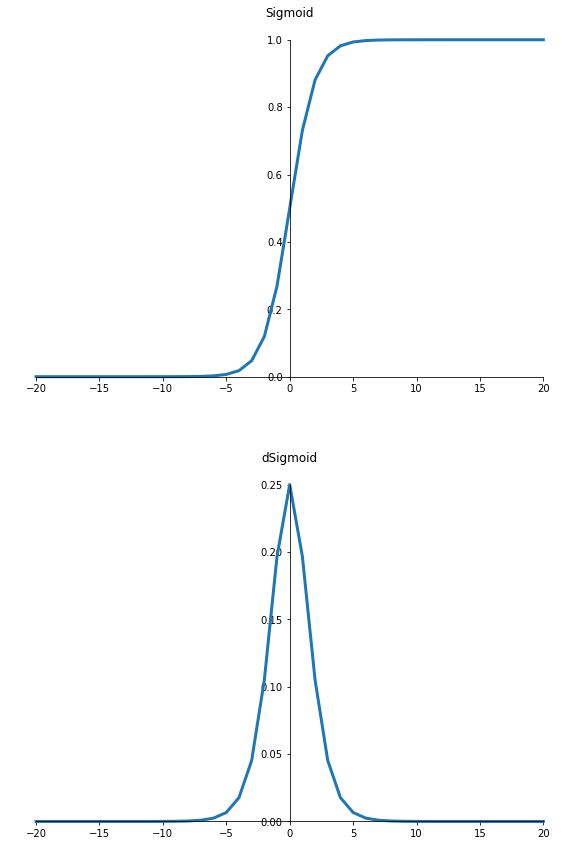

In [56]:
fig, (ax0, ax1) = plot.subplots(nrows=2, figsize=(10,15))

ax0.plot(x, sg, linewidth=3)
ax0.spines['bottom'].set_position('zero')
ax0.set_title('Sigmoid')

ax1.plot(x, sg_, linewidth=3)
ax1.spines['bottom'].set_position('zero')
ax1.set_title('dSigmoid')

for ax in (ax0, ax1):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.spines['left'].set_position('center')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.get_yaxis().tick_left()


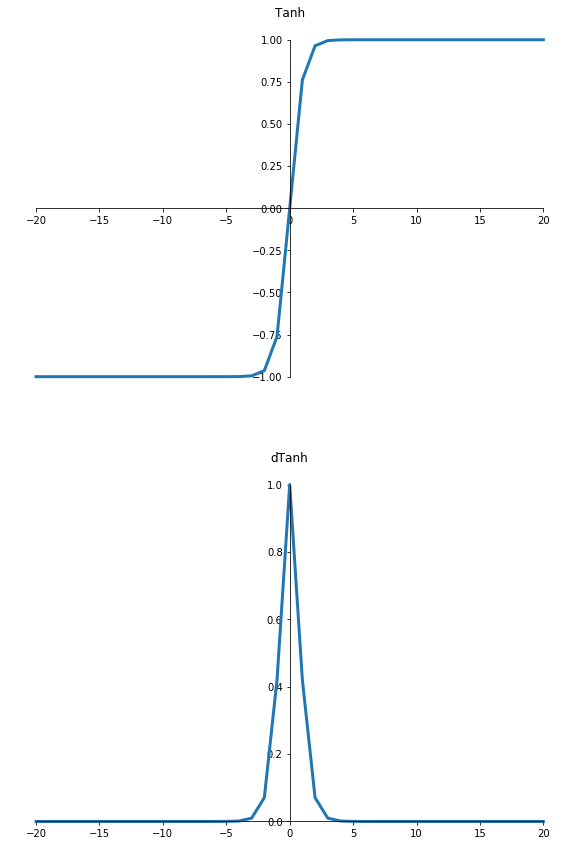

In [57]:
fig, (ax0, ax1) = plot.subplots(nrows=2, figsize=(10,15))

ax0.plot(x, th, linewidth=3)
ax0.spines['bottom'].set_position('center')
ax0.set_title('Tanh')

ax1.plot(x, th_, linewidth=3)
ax1.spines['bottom'].set_position('zero')
ax1.set_title('dTanh')

for ax in (ax0, ax1):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.spines['left'].set_position('center')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.get_yaxis().tick_left()

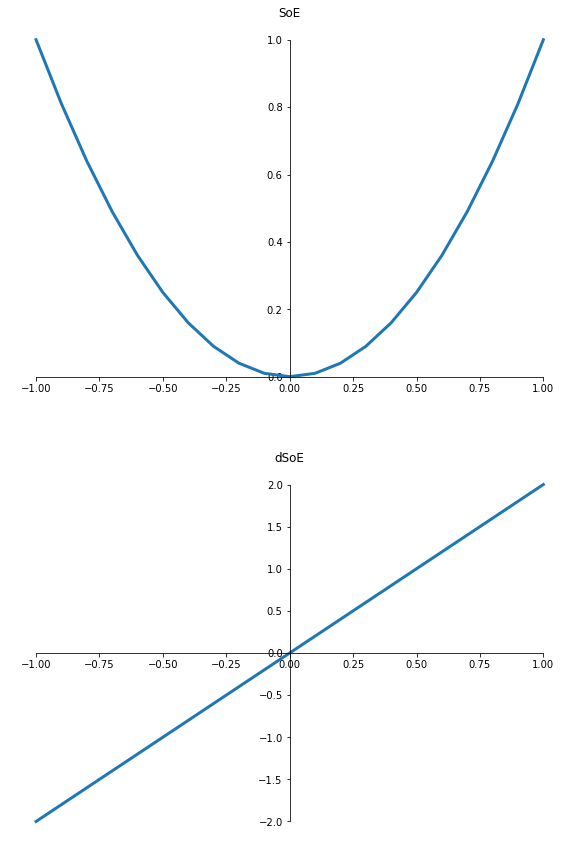

In [65]:
fig, (ax0, ax1) = plot.subplots(nrows=2, figsize=(10,15))

ax0.plot(x_c, c, linewidth=3)
ax0.spines['bottom'].set_position('zero')
ax0.set_title('SoE')

ax1.plot(x_c, c_, linewidth=3)
ax1.spines['bottom'].set_position('zero')
ax1.set_title('dSoE')

for ax in (ax0, ax1):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.spines['left'].set_position('center')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.get_yaxis().tick_left()